<a href="https://colab.research.google.com/github/GorokhovSemyon/TextClassification/blob/main/Knowledge_graphs_with_LLM_driven_entity_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Построение графов знаний с помощью извлечения сущностей, управляемого LLM

[txtai](https://github.com/neuml/txtai) - это универсальная база данных для семантического поиска, оркестровки LLM и рабочих процессов с использованием языковых моделей.

Базы данных Embeddings представляют собой объединение векторных индексов (разреженных и плотных), графовых сетей и реляционных баз данных. Это позволяет осуществлять векторный поиск с помощью SQL, тематическое моделирование, расширенную генерацию результатов поиска и многое другое.

Вплоть до версии txtai 7.0 семантические графы поддерживали только автоматическое определение связей. Теперь связи можно загружать непосредственно в базу данных txtai. Этом ноутбуке будет продемонстрировано, как работать с этой новой функцией.

# Установка зависимостей

Установка `txtai` и всех сопутствующих зависимостей.

In [3]:
%%capture
!pip install txtai==7.0.0
!pip install grand-cypher>=0.6.0 networkx>=2.6.3 python-louvain>=0.16

# Загрузка базы данных Википедии

В базе данных [текстовая википедия](https://huggingface.co/Neumel/textual-wikipedia) хранятся резюме всех статей Википедии по состоянию на январь 2024 года. Эта база данных - отличный способ изучить широкий спектр тем. В него также встроено количество просмотров страниц, что позволяет просматривать часто просматриваемые или популярные статьи по теме.

В этом примере мы будем работать со статьями, связанными с `величайшими изобретениями человечества`.

In [ ]:
from txtai import Embeddings

# Load dataset
wikipedia = Embeddings()
wikipedia.load(provider="huggingface-hub", container="neuml/txtai-wikipedia")

query = """
SELECT id, text FROM txtai WHERE similar('величайшие изобретения человечества') and percentile >= 0.5
"""

results = wikipedia.search(query, 5)

for x in results:
    print(x)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

documents:   0%|          | 0.00/3.24G [00:00<?, ?B/s]

embeddings:   0%|          | 0.00/4.80G [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/356 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

{'id': 'Valinke', 'text': 'Валинке is a national folklore ensemble of riding Chuvashs of Alikovsky District of the Chuvash Republic. It is part of a collection of about 60 masters of national art creativity.'}
{'id': 'Intransigence', 'text': 'Intransigence (Russian: непримири́мость) is an ideological and political principle that was formed within the framework of the White Movement in the early years of emigration.'}
{'id': 'Istoricheskie Zapiski', 'text': 'Istoricheskie Zapiski (Исторические записки) (Historical Transactions), also known as ИЗ, is an academic journal of history published by Progress Publishers in Moscow for the Russian Academy of Sciences and its predecessors since 1937. The journal specialises in medieval and modern Russian history and until 1957 was one of just three journals available to Soviet historians, the others being Voprosy Istorii, which took a more historiographical approach, and Vestnik Drevnei Istorii which dealt with ancient history.'}
{'id': 'Obrazovan

# Извлечение сущностей с помощью LLM

Теперь, когда у нас есть пара соответствующих статей, давайте рассмотрим и запустим процесс извлечения сущностей. Для этой задачи подойдёт LLM.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
torch.manual_seed(42)

data = []
model_name = "t-bank-ai/T-lite-instruct-0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

for result in results:
  messages = [
      {"role": "user", "content": f"""Ты дружелюбный ассистент, отвечающий на вопросы пользователей.
    Извлеки график взаимосвязи сущностей из следующего текста, переведя на русский. Выведи в формате JSON.
    Узлы должны иметь атрибуты label и type. Ребра должны иметь атрибуты source, target и relationship.

    text: {result['text']}"""},
  ]

  input_ids = tokenizer.apply_chat_template(
      messages,
      add_generation_prompt=True,
      return_tensors="pt"
  ).to(model.device)

  terminators = [
      tokenizer.eos_token_id,
      tokenizer.convert_tokens_to_ids("<|eot_id|>")
  ]

  outputs = model.generate(
      input_ids,
      max_new_tokens=256,
      eos_token_id=terminators,
  )

  res = tokenizer.decode(outputs[0], skip_special_tokens=True)
  data.append(res)
  print(res)


## Результат инференса, полученный отдельно

Было интересно посмотреть, насколько хорошо модель справиться с параллельной задачей перевода и получилось неплохо.

Модель не получилось запустить в colab, поэтому делал это отдельно на собственных GPU ресурсах.

In [12]:
import json
data = json.loads("""[
    {
        "nodes": [
            {"label": "Валинке", "text": "Валинке - это национальный фольклорный ансамбль верховых чувашей из Аликовского района Чувашской Республики. Он является частью коллекции примерно из 60 мастеров национального художественного творчества."},
            {"label": "Непримиримость", "text": "Непримири́мость (Intransigence) - это идеологический и политический принцип, возникший в рамках Белого Движения в ранние годы эмиграции."},
            {"label": "Исторические записки", "text": "Исторические записки (Historical Transactions), также известные как ИЗ, - это академический журнал по истории, издаваемый издательством Прогресс в Москве для Российской академии наук и ее предшественников с 1937 года. Журнал специализируется на средневековой и современной русской истории и до 1957 года был одним из трех доступных советским историкам журналов, другими были Вопросы Истории, которые занимались более историографическим подходом, и Вестник Древней Истории, который занимался древней историей."},
            {"label": "Образованщина", "text": "Образованщина (educationdom, educaties, smatterers) - это русский иронический, оскорбительный термин для категории людей со поверхностным образованием, которым не хватает высших этических принципов образованного человека."},
            {"label": "Артподготовка", "text": "Артподготовка (Artillery - or art - preparation), также известная как Межрегиональное общественное движение 'Артподготовка', - это российская политическая организация левого националистического характера. Признана экстремистской и запрещена на территории Российской Федерации."}
        ],
        "edges": [
            {"source": "Валинке", "target": "Исторические записки", "relationship": "Сообщает"},
            {"source": "Непримириимость", "target": "Артподготовка", "relationship": "Противостоит"},
            {"source": "Образованщина", "target": "Исторические записки", "relationship": "Цитирует"}
        ]
    }
]""")

In [13]:
data

[{'nodes': [{'label': 'Валинке',
    'text': 'Валинке - это национальный фольклорный ансамбль верховых чувашей из Аликовского района Чувашской Республики. Он является частью коллекции примерно из 60 мастеров национального художественного творчества.'},
   {'label': 'Непримиримость',
    'text': 'Непримири́мость (Intransigence) - это идеологический и политический принцип, возникший в рамках Белого Движения в ранние годы эмиграции.'},
   {'label': 'Исторические записки',
    'text': 'Исторические записки (Historical Transactions), также известные как ИЗ, - это академический журнал по истории, издаваемый издательством Прогресс в Москве для Российской академии наук и ее предшественников с 1937 года. Журнал специализируется на средневековой и современной русской истории и до 1957 года был одним из трех доступных советским историкам журналов, другими были Вопросы Истории, которые занимались более историографическим подходом, и Вестник Древней Истории, который занимался древней историей.'},
 

# Build an embeddings database

Now that we've extracted entities from the documents, next we'll review and load a graph network using these entity-relationships.

In [14]:
import networkx
from txtai import Embeddings

def stream():
    nodes = {}

    for row in data.copy():
        # Create nodes
        for node in row["nodes"]:
            if node["label"] not in nodes:
                node["id"] = len(nodes)
                nodes[node["label"]] = node

        for edge in row["edges"]:
            source = nodes.get(edge["source"])
            target = nodes.get(edge["target"])

            if source and target:
                if "relationships" not in source:
                    source["relationships"] = []

                source["relationships"].append({"id": target["id"], "relationship": edge["relationship"]})

    return nodes.values()

# Create embeddings instance with a semantic graph
embeddings = Embeddings(
    autoid = "uuid5",
    path = "intfloat/e5-base",
    instructions = {
        "query": "query: ",
        "data": "passage: "
    },
    columns = {
        "text": "label"
    },
    content = True,
    graph = {
        "approximate": False,
        "topics": {}
    }
)

embeddings.index(stream())

# Связи

Теперь давайте представим себе сеть сущностей и отношений.

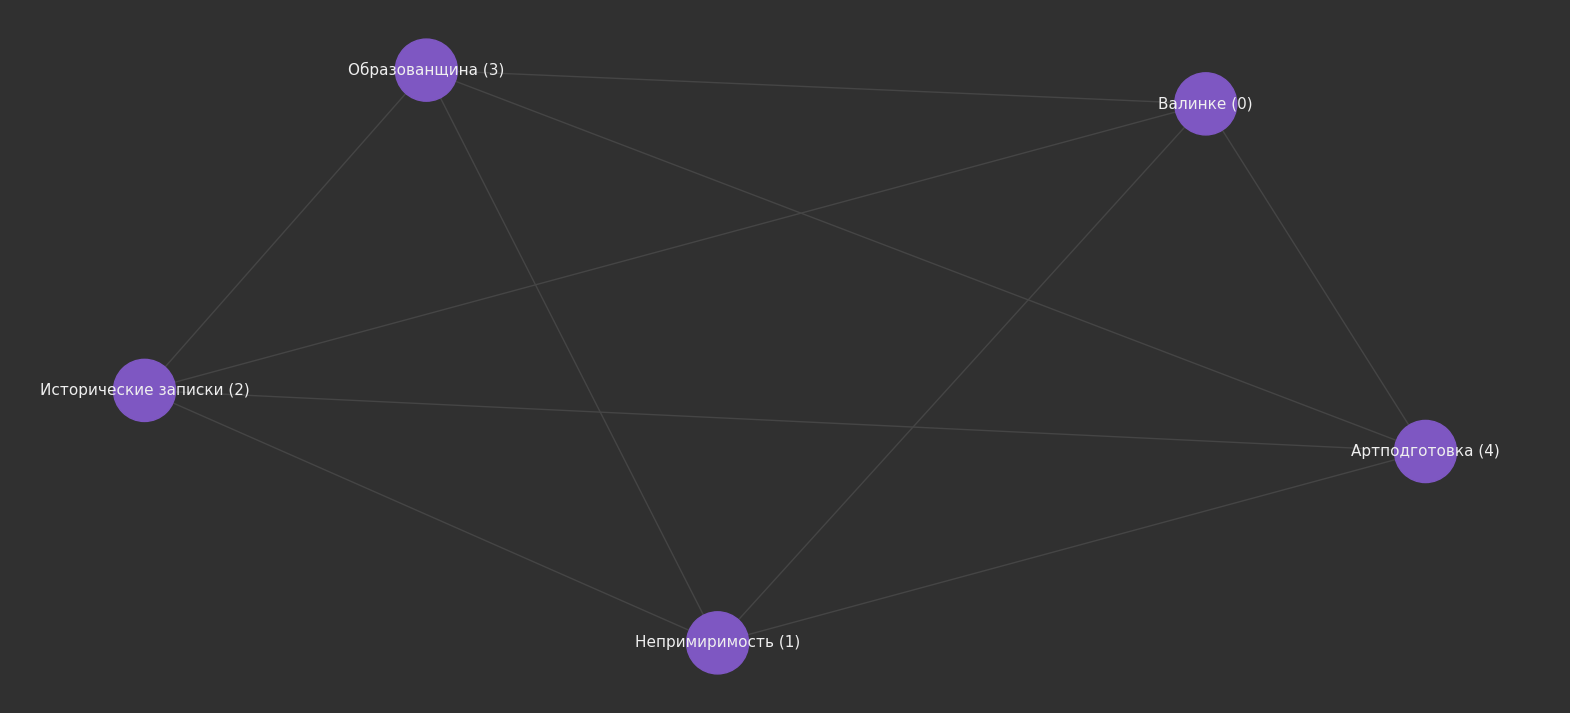

In [15]:
import matplotlib.pyplot as plt
import networkx as nx

def plot(graph):
    labels = {x: f"{graph.attribute(x, 'text')} ({x})" for x in graph.scan()}
    lookup = {
      "Person": "#d32f2f",
      "Location": "#0277bd",
      "Event": "#e64980",
      "Role": "#757575"
    }

    colors = []
    for x in graph.scan():
      value = embeddings.search("select type from txtai where id = :x", parameters={"x": x})[0]["type"]
      colors.append(lookup.get(value, "#7e57c2"))

    options = {
        "node_size": 2000,
        "node_color": colors,
        "edge_color": "#454545",
        "font_color": "#efefef",
        "font_size": 11,
        "alpha": 1.0
    }

    fig, ax = plt.subplots(figsize=(20, 9))
    pos = nx.spring_layout(graph.backend, seed=0, k=3, iterations=250)
    nx.draw_networkx(graph.backend, pos=pos, labels=labels, **options)
    ax.set_facecolor("#303030")
    ax.axis("off")
    fig.set_facecolor("#303030")

plot(embeddings.graph)

# Выводы

В этом ноутбуке показано, как можно создавать графы знаний извлекая сущности с помощью LLM. Автоматически выводимые связи с помощью семантического сходства!

Комбинация графов знаний и больших языковых моделей (LLM) представляет собой сильный инструмент для обработки текстовых данных. Графы знаний обогащают анализ текста, позволяя детально изучать взаимосвязи между сущностями и улучшать контекстуальное понимание, что дополняет возможности LLM в обработке текста. Использование графов для уточнения контекста модели LLM значительно повышает качество генерации текста, а также помогает расширить базу знаний, что способствует более глубокому пониманию текста. Таким образом, данное сочетание представляет важный инструмент для задач обработки естественного языка и искусственного интеллекта, существенно обогащая анализ текстов и способствуя точной и информативной генерации текста.